In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units, cosmology


In [2]:
from limstat.simulations import cosmological_signal
from limstat.power_spectrum import power_spectrum

In [3]:
%load_ext autoreload
%autoreload 2

## Parameters

In [4]:
# Simulation angular specs
ang_res = 15.*units.arcsec # angular resolution
#number of pixels in row and col (ang res)
npix = 200
#length and width of the box in Mpc
fov = ang_res.to(units.rad) * npix #rad

In [5]:
# Simulation spectral specs
nfreqs = 15
df = 100e3 * units.Hz
avg_nu = 150.e6 * units.Hz

spw_window = np.arange(avg_nu.value - df.value*nfreqs//2,
                       avg_nu.value + df.value*(nfreqs//2),
                       step=df.value) * units.Hz

print(f'{spw_window.size} frequency channels, '
      f'mean frequency {avg_nu.to(units.MHz):.1f}.')

15 frequency channels, mean frequency 150.0 MHz.


## Define a `cosmological_signal` object

Initialise the object with the following attributes:
* The frequencies along the considered spectral window, `freqs`. It must be an array with `astropy.units`.
* The number of pixels in the sky plane (for a square FoV: npix * npix).
* The angular resolution of the observation. Must be an `astropy.Quantity` with units.
* The required power spectrum for the cosmological Gaussian random field. Can be a function (see below) or an array of shape (2, nk) with k values in the first column and corresponding P(k) in the second. The array is then interpolated.
* An `astropy.cosmology` can be specified. The default is `cosmology.Planck18`.

In [11]:
def flat_ps(k, amp=1e-3):
        """
        Generate a flat power spectrum of amplitude amp.

        Parameters
        ----------
                k: float or array of flats
                Fourier mode in Mpc-1.
                amp: float
                Desired amplitude for the PS, in K2.

        """
        k = np.atleast_1d(k)
        return amp * np.ones(k.shape)

In [12]:
# Define object
universe = cosmological_signal(
    ps=flat_ps,
    freqs=spw_window,
    npix=npix,
    ang_res=ang_res,
    verbose=True
)
# Generate simulation box for a given amplitude of the flat power spectrum
amp = 10.e-3
box = universe.make_universe(amp=amp)

Taking iFFT of box
Mean of simulated box = -1.869e-20


Let's show the observed cosmological signal:

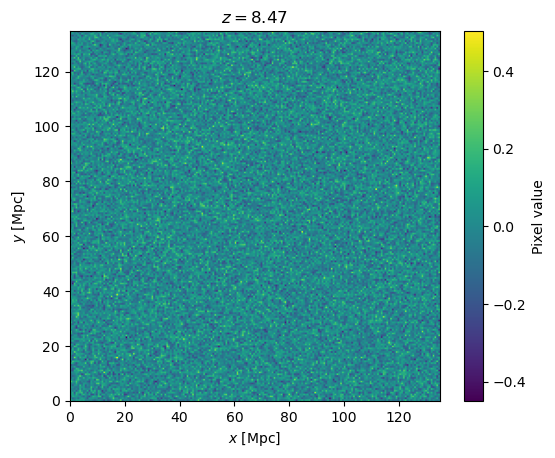

In [13]:
plt.figure()
plt.imshow(box[:, :, universe.nfreqs//2],
           origin='lower',
           extent=(0, universe.L, 0, universe.L))
plt.xlabel(r'$x$ [Mpc]')
plt.ylabel(r'$y$ [Mpc]')
plt.title(fr'$z={universe.avg_z:.2f}$')
plt.colorbar(label='Pixel value')

## Compare output and required power spectrum

In [14]:
# Define power spectrum object with appropriate parameters
# For this, we need to assume a cosmology, as well as interpret the pixel values as brightness temperatures
pspec = power_spectrum(
    data=box,
    theta_x=fov,
    theta_y=fov,
    freqs=spw_window,
    rest_freq=1420 * units.MHz,
    cosmo=cosmology.Planck18,
    convert_data_to=None,
    verbose=False
)
# Compute spherical PS
kweights, pspec_1d = pspec.compute_1D_pspec()

/Users/adeliegorce/Library/CloudStorage/OneDrive-McGillUniversity/Research/SKA_Data_challenge/SKA_SDC3/ska_simulator/ska_simulator/power_spectrum.py:137: UserWarning: Provided data does not have units. Assuming the input is provided in mK.
  self.data = utils.comply_units(
/Users/adeliegorce/Library/CloudStorage/OneDrive-McGillUniversity/Research/SKA_Data_challenge/SKA_SDC3/ska_simulator/ska_simulator/power_spectrum.py:829: UserWarning: Assuming ps_data is in mK**2 Mpc3.
  warnings.warn(f"Assuming ps_data is in {self.data_unit}**2 Mpc3.")


(0.9, 1.1)

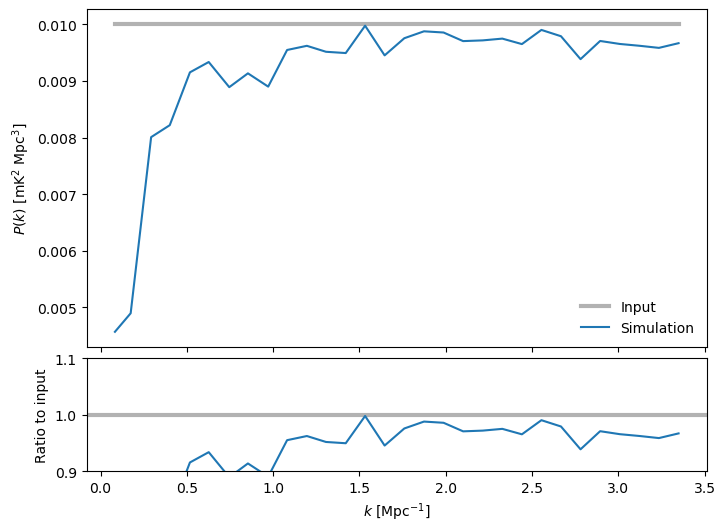

In [22]:
# Compare results
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                         gridspec_kw={'height_ratios':(3, 1), 'hspace':0.05})

# spectra
axes[0].plot(kweights, flat_ps(kweights, amp), label = 'Input',
             color='k', lw=3., alpha=.3)
axes[0].plot(kweights, pspec_1d, label = 'Simulation')

# ratio
axes[1].axhline(1, color='k', lw=3., alpha=.3)
axes[1].plot(kweights, pspec_1d/flat_ps(kweights, amp))

axes[0].set_ylabel(rf"$P(k)$ [{pspec.data_unit}$^2$ Mpc$^3$]")
axes[1].set_ylabel(r"Ratio to input")
axes[-1].set_xlabel(r"$k$ [Mpc$^{-1}$]")
axes[0].legend(loc = 'best', frameon=False)
axes[-1].set_ylim(0.9, 1.1)
# axes[0].set_ylim(amp*0.9, amp*1.1)

There is a reasonably good match between the power spectrum of the simulation and the power spectrum required as input.